# import data


In [2]:
library(dplyr)
library(liger)
library(cowplot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: cowplot
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: Matrix
Loading required package: patchwork


In [3]:
# from nor-TCGA data
all_data = read.table('/cellar/users/hsher/Data/normalized_kmer/nor_four.csv', sep = ',', row.names = 1, header = TRUE, nrows = 5000)
all_data = all_data * 100000

# sepeerate TCGA by capture kit
capture_kits <- read.table('/cellar/users/ramarty/Data/kir/ref/sample.capture.kit', sep = '\t', header = T)
# remove dups
capture_kits <- distinct(capture_kits, SHORT_ID, .keep_all = TRUE)
# select only the ones that are in the loaded data
capture_kits <- subset(capture_kits, capture_kits$SHORT_ID %in% row.names(all_data))
# group by capture kit
unique(capture_kits$KIT)

ag = subset(all_data, row.names(all_data) %in% capture_kits$SHORT_ID[capture_kits$KIT == 'Agilent Custom'])
su = subset(all_data, row.names(all_data) %in% capture_kits$SHORT_ID[capture_kits$KIT == 'Sureselect.38'])
nim1 = subset(all_data, row.names(all_data) %in% capture_kits$SHORT_ID[capture_kits$KIT == 'Nimblegen HGSC'])
nim2 = subset(all_data, row.names(all_data) %in% capture_kits$SHORT_ID[capture_kits$KIT == 'Nimblegen.SQEZ2'])
nim3 = subset(all_data, row.names(all_data) %in% capture_kits$SHORT_ID[capture_kits$KIT == 'Nimblegen hg18'])
nim4 = subset(all_data, row.names(all_data) %in% capture_kits$SHORT_ID[capture_kits$KIT == 'Nimblegen.SQEZ3'])

[1] Agilent Custom  Sureselect.38   Nimblegen.SQEZ2 Nimblegen HGSC 
[5] Nimblegen hg18  Nimblegen.SQEZ3
6 Levels: Agilent Custom Nimblegen hg18 Nimblegen HGSC ... Sureselect.38

In [4]:
# from dbGap_data
dbGap = read.table('~/Data/normalized_kmer/nor_dbGap.csv', sep = ',', row.names = 1, header = TRUE)
KhoeSan = read.table('~/Data/normalized_kmer/nor_KhoeSan.csv', sep = ',', row.names = 1, header = TRUE)

In [5]:
# joined dataset make liger object
sep_by_kit <- list(Agilent=t(ag), Sureselect=t(su), Nimblegen_hgsc=t(nim1), Nimblegen_sqez2=t(nim2), Nimblegen_hg18=t(nim3), Numblegen_sqez3=t(nim4), dbGap = t(dbGap), KhoeSan = t(KhoeSan))

In [6]:
a.pbmc <- createLiger(sep_by_kit)

[1] "Removing 5 cells not expressing any genes in Agilent."
[1] "TCGA-HU-A4GP" "TCGA-EJ-7783" "TCGA-HC-7211" "TCGA-CH-5761" "TCGA-CJ-4904"
[1] "Removing 3 cells not expressing any genes in Nimblegen_sqez2."
[1] "TCGA-L5-A8NN" "TCGA-EY-A2ON" "TCGA-AX-A0IZ"
[1] "Removing 11 cells not expressing any genes in dbGap."
 [1] "SRR1034704" "SRR1034743" "SRR886352"  "SRR886364"  "SRR886440" 
 [6] "SRR776736"  "SRR777342"  "SRR777474"  "SRR780126"  "SRR781707" 
[11] "SRR781773" 
[1] "Removing 4 genes not expressing in Sureselect."
[1] "CTTCTGTTCCCTGCAGGCTC" "ACTTCTGTTCCCTGCAGGCT" "CACTTCTGTTCCCTGCAGGC"
[4] "TCACTTCTGTTCCCTGCAGG"
[1] "Removing 20 genes not expressing in Nimblegen_sqez2."
 [1] "GGCAGGCTCTTGGTCCATTA" "CGGCAGGCTCTTGGTCCATT" "CCGGCAGGCTCTTGGTCCAT"
 [4] "TCTGTCCCCGGCAGGCTCTT" "TTCTGTCCCCGGCAGGCTCT" "TGTTCTGTCCCCGGCAGGCT"
 [7] "ACTGTTCTGTCCCCGGCAGG" "CACTGTTCTGTCCCCGGCAG" "TCACTGTTCTGTCCCCGGCA"
[10] "TTCACTGTTCTGTCCCCGGC" "GTTCACTGTTCTGTCCCCGG" "TGTTCACTGTTCTGTCCCCG"
[13] "CTGTTCACTGTTC

In [7]:
a.pbmc <- normalize(a.pbmc)

In [8]:
a.pbmc <- selectGenes(a.pbmc, var.thresh = 0.3, do.plot = F) 

In [9]:
a.pbmc <- scaleNotCenter(a.pbmc)

[1] "Removing 1 genes not expressing in dbGap."
[1] "SRR779019"


In [10]:
a.pbmc <- optimizeALS(a.pbmc, k=12, thresh = 5e-5, nrep = 3)# can't do w/o scale not center

  |======================================================================| 100%
Converged in 3.812956 mins, 51 iterations.
  |======================================================================| 100%
Converged in 4.031541 mins, 54 iterations.
  |======================================================================| 100%
Converged in 2.182489 mins, 29 iterations.
Best results with seed 1.


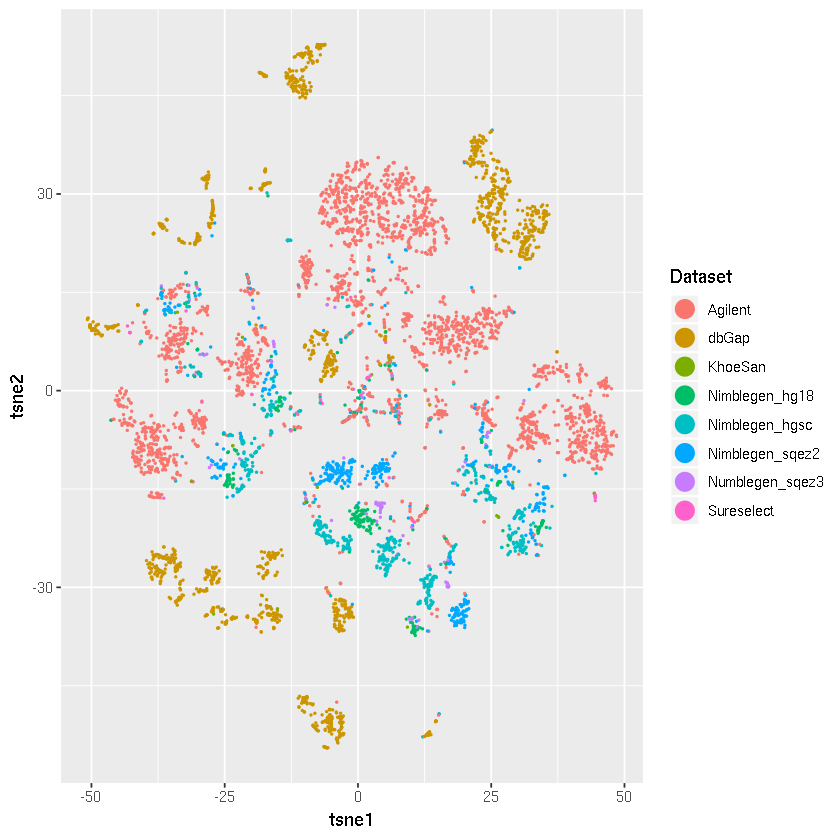

In [11]:
a.pbmc <- runTSNE(a.pbmc, use.raw = T)
p1 <- plotByDatasetAndCluster(a.pbmc, return.plots = T)
# Plot by dataset
print(p1[[1]]) 

In [12]:
a.pbmc <- quantileAlignSNF(a.pbmc, resolution = 0.4, small.clust.thresh = 20)
# align by similar neiborhood profile
# Could also forgo small cluster extraction if desired
# a.pbmc <- quantileAlignSNF(a.pbmc, resolution = 0.4)

[1] "Recomputing shared nearest factor space"


Warning message in get.knn(data = norm, k = knn_k, algorithm = dist.use):
“k should be less than sample size!”

[1] "Isolating small clusters with fewer than 20 members"
[1] "making edge file."
[1] "Starting SLM"
[1] "Assigning singletons"


Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in r

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to uniqu

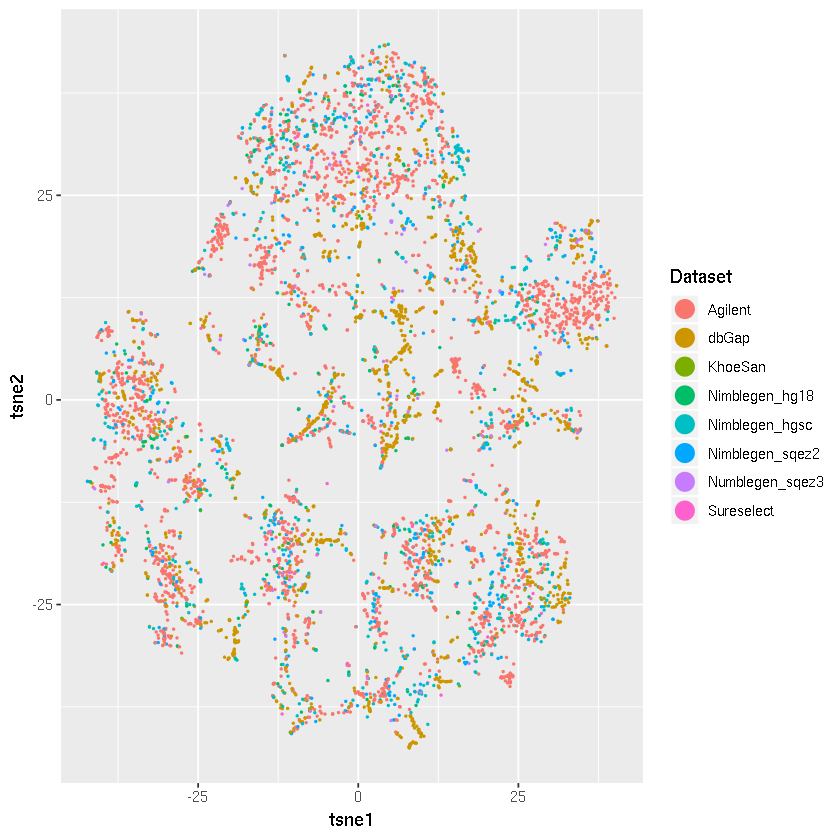

In [13]:
a.pbmc <- runTSNE(a.pbmc)
p_a <- plotByDatasetAndCluster(a.pbmc, return.plots = T) 
# Modify plot output slightly
print(p_a[[1]])
# better huh

In [14]:
write.csv(a.pbmc@H.norm, '~/Data/liger_output/all_hnorm.csv') # 12 factors, normalized by cluster
write.csv(a.pbmc@W, '~/Data/liger_output/all_w.csv') # shared matrix
write.csv(a.pbmc@tsne.coords, '~/Data/liger_output/all_tsne.csv')